<a href="https://colab.research.google.com/github/rhilderbrand/MSDS-422-MachineLearning/blob/main/Hilderbrand_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 3: Evaluating Classification Models

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [ ]:
# Load necessary packages
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import base packages into the namespace for this program
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from pandas.plotting import scatter_matrix

In [ ]:
# output of plotting commands is displayed inline directly below the code cell that produced it
%matplotlib inline

In [ ]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

In [ ]:
#S2 Mount Google Drive to Colab Enviorment
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#S3 Establish working directory
import os # Operation System
os.getcwd()
%cd /content/gdrive/My Drive/Colab Notebooks/Week 3/
!pwd
!ls
print('Working Directory')
print(os.getcwd())

'/content'

/content/gdrive/My Drive/Colab Notebooks/Week 3
/content/gdrive/My Drive/Colab Notebooks/Week 3
bank.csv		  plot-corr-map.pdf
Hilderbrand_Assignment_3  PML_Assignment3_GettingStarted.ipynb
Working Directory
/content/gdrive/My Drive/Colab Notebooks/Week 3


In [ ]:
# Load data
work_dir = " /content/gdrive/My Drive/Colab Notebooks/Week 3/"
bank = pd.read_csv('bank.csv', sep=';')

##Exploratory Data Analysis

**Data Dictionary**

**age** - age in years

**job** - type of job (admin, unknown, unemployed, management, housemaid, entrepreneur, student, blue-collar, self-employed, retired, technician, services)

**education** - Level of eduction (unknown, secondary, primary, tertiary)

**default** - has credit in default? (yes, no)

**balance** - average yearly balance (in euros)

**housing** - has housing loan? (yes, no)

**loan** - has personal loan? (yes, no)

**contact** - contact communication type (unknown, telephone, cellular)

**day** - last contact day of the month

**month** - last contact month of year

**duration** - last contact duration (in seconds)

**campaign** - number of contacts performed during this campaign for this client (includes last contact)

**pdays** - number of contacts performed before this campaign for this client

**poutcome** - outcome of previous marketing campaighn (unknown, other, failure, success)

**response** - response to most recent marketing contact/call has the client subscribed to a term deposit? (yes, no)

In [ ]:
# print first and last five rows of the df
bank.head()
bank.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no
4520,44,entrepreneur,single,tertiary,no,1136,yes,yes,cellular,3,apr,345,2,249,7,other,no


In [ ]:
# Look at df general info
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  response   4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [ ]:
# examine the shape of original input data
print(bank.shape)

(4521, 17)


We see from the data frame info that there doesn't seem to be any missing or null values for any features, but we double check for null values using isnull() and confirm there aren't any null values.

In [ ]:
# check for any null values
bank.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
response     0
dtype: int64

Looking at the list of columns allows us to look at the features. We determine that the response column is our target variable.

In [ ]:
# look at the list of column names
list(bank.columns.values)

# look at the beginning of the DataFrame
bank.head()

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'response']

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [ ]:
# Descriptive Statistics for non-categorical variables
bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


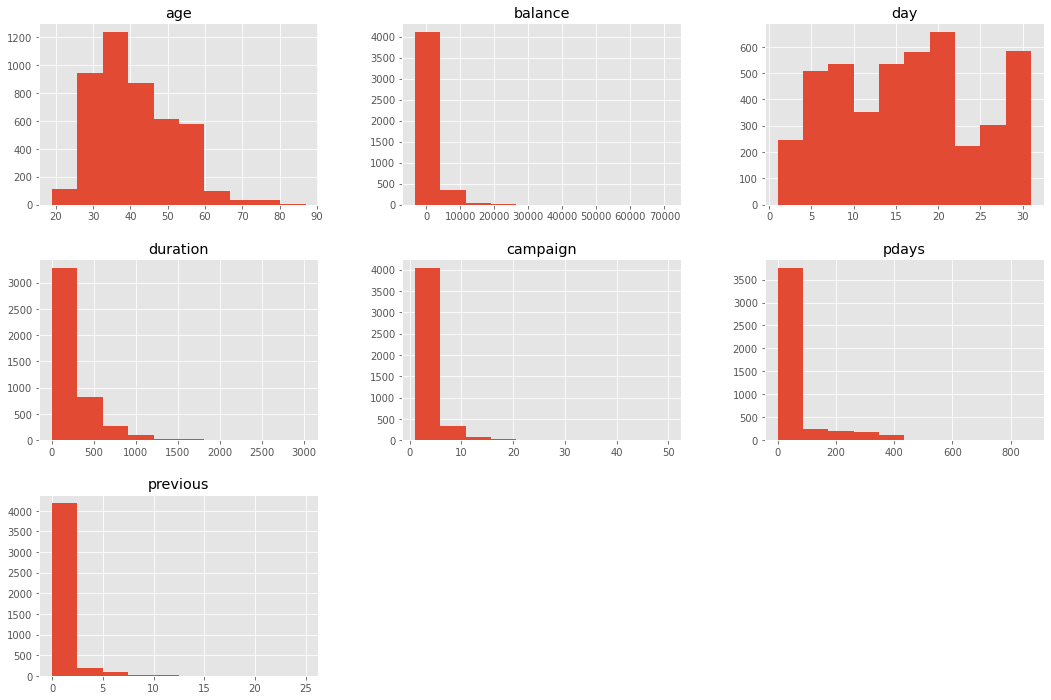

In [ ]:
# Check distributions of non-categorical variables
bank.hist(figsize=(18,12));

In [ ]:
bank['response'].value_counts()

no     4000
yes     521
Name: response, dtype: int64

<Figure size 432x288 with 0 Axes>

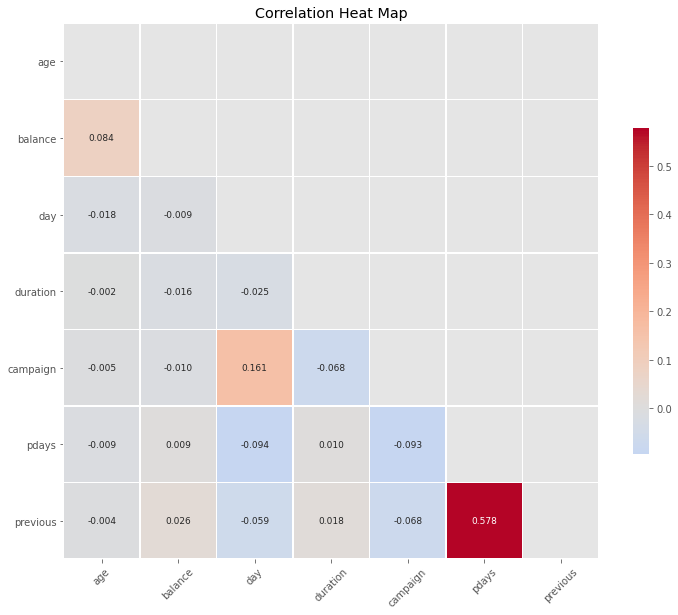

In [ ]:
# correlation heat map setup for seaborn
def corr_chart(df_corr):
    corr=df_corr.corr()
    #screen top half to get a triangle
    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr, mask=top, cmap='coolwarm', 
        center = 0, square=True, 
        linewidths=.5, cbar_kws={'shrink':.5}, 
        annot = True, annot_kws={'size': 9}, fmt = '.3f')           
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')   
    plt.savefig('plot-corr-map.pdf', 
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
        orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25, frameon=None)      

np.set_printoptions(precision=3)

# examine correlations
corr_chart(df_corr = bank) 

In [ ]:
# mapping function to convert text no/yes to integer 0/1
convert_to_binary = {'no' : 0, 'yes' : 1}

# define binary variable for having credit in default
default = bank['default'].map(convert_to_binary)

# define binary variable for having a mortgage or housing loan
housing = bank['housing'].map(convert_to_binary)

# define binary variable for having a personal loan
loan = bank['loan'].map(convert_to_binary)

# define response variable to use in the model
response = bank['response'].map(convert_to_binary)

# gather three explanatory variables and response into a numpy array 
# here we use .T to obtain the transpose for the structure we want
model_data = np.array([np.array(default), np.array(housing), np.array(loan), 
    np.array(response)]).T

# examine the shape of model_data, which we will use in subsequent modeling
print(model_data.shape)

(4521, 4)


In [ ]:
#Check "model_data" structure
print(model_data)

[[0 0 0 0]
 [0 1 1 0]
 [0 1 0 0]
 ...
 [0 0 0 0]
 [0 0 0 0]
 [0 1 1 0]]


In [ ]:
# Check the frequency of "default", "loan", "housing" by "response"
(pd.crosstab([bank['default'],bank['loan'],bank['housing']], [bank['response']], margins=True))

# pd.crosstab([bank['default'],bank['loan'],bank['housing']],columns=bank['response'])

# # Check the frequency of "default", "loan", "housing" by "response"
# print(pd.crosstab([bank['default'],bank['loan'],bank['housing']], [bank['response']], margins=True))

response                no  yes   All
default loan housing                 
no      no   no       1381  279  1660
             yes      1927  192  2119
        yes  no        255   16   271
             yes       370   25   395
yes     no   no         13    4    17
             yes        31    3    34
        yes  no         12    2    14
             yes        11    0    11
All                   4000  521  4521

In [ ]:
ct = (pd.crosstab([bank['default'],bank['loan'],bank['housing']], 
                  [bank['response']], margins=True))
ct_nm = (pd.crosstab([bank['default'],bank['loan'],bank['housing']], 
                  [bank['response']], margins=False))
ct2 = pd.crosstab(bank.response,bank.default)
ct3 = pd.crosstab(bank.response,bank.loan)
ct4 = pd.crosstab(bank.response,bank.housing)

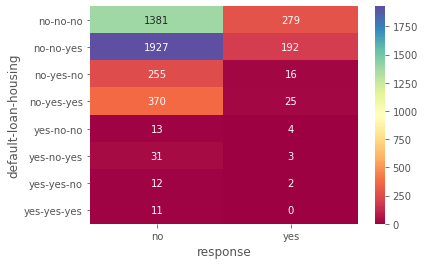

<Figure size 432x288 with 0 Axes>

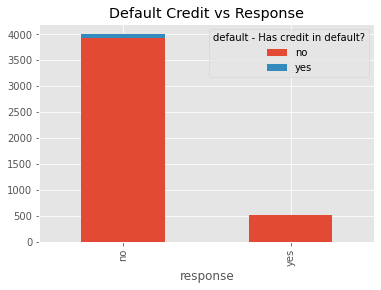

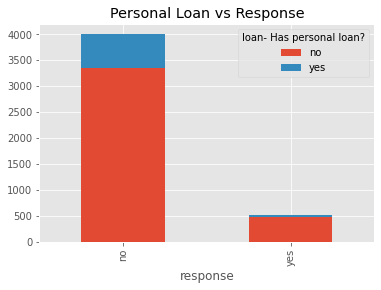

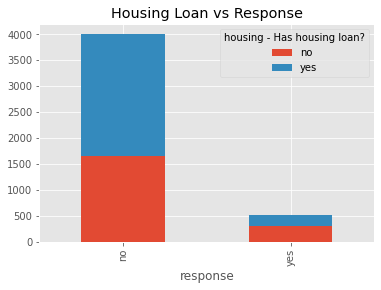

In [ ]:
plt.figure()
sns.heatmap(ct_nm,cmap="Spectral", annot=True, cbar=True,fmt='g');

plt.figure()
ct2.plot.bar(stacked=True)
plt.legend(title='default - Has credit in default?')
plt.title("Default Credit vs Response")
plt.show();

ct3.plot.bar(stacked=True)
plt.legend(title='loan- Has personal loan?')
plt.title("Personal Loan vs Response")
plt.show();

ct4.plot.bar(stacked=True)
plt.legend(title='housing - Has housing loan?')
plt.title("Housing Loan vs Response")
plt.show();

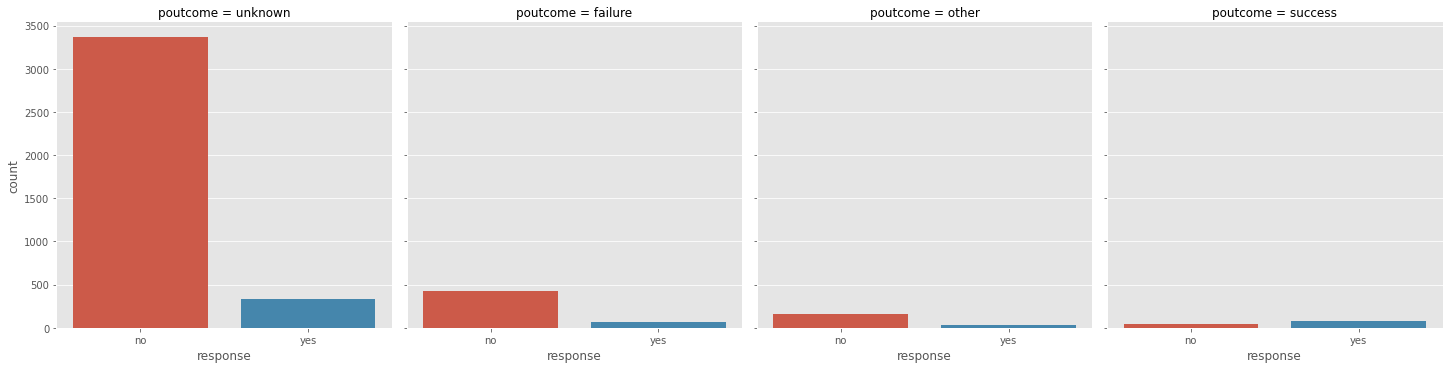

In [ ]:
sns.catplot(x="response", col="poutcome", data=bank, kind="count")

In [ ]:
# shuffle is by the first index, which is the rows
np.random.seed(RANDOM_SEED)
np.random.shuffle(model_data)

# dimensions of the additive model X input and y response
print('\nData dimensions:', model_data.shape)

# --------------------------------------------------------


Data dimensions: (4521, 4)


In [ ]:
# Prepare Data for Model
model_data = np.array( [ np.array(default), np.array(housing), np.array(loan), np.array(response)]).T

In [ ]:
# Ensure we have the same number of observations.
assert len(bank) == len(model_data)

In [ ]:
model_data.shape

(4521, 4)

## Classification Models

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
# import Logistic Regression model
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

names = ["Naive_Bayes","Logistic_Regression"]
classifiers = [BernoulliNB(alpha=1.0, binarize=0.5, class_prior = [0.5, 0.5], fit_prior=False), LogisticRegression(solver='lbfgs')]

# dimensions of the additive model X input and y response
print('\nData dimensions:', model_data.shape)


Data dimensions: (4521, 4)


In [ ]:
# specify the k-fold cross-validation design
from sklearn.model_selection import KFold

from sklearn.metrics import roc_curve

In [ ]:
# ten-fold cross-validation employed here
N_FOLDS = 10

# set up numpy array for storing results
cv_results = np.zeros((N_FOLDS, len(classifier_names)))


Fold index: 0 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4068, 3)
X_test: (453, 3)
y_train: (4068,)
y_test: (453,)

Classifier evaluation for: Logistic_Regression
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)


BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

Area under ROC curve: 0.5878522062732588


<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

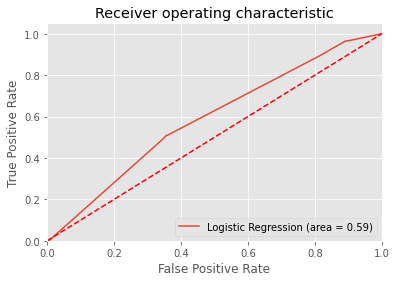


Classifier evaluation for: Naive_Bayes
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Area under ROC curve: 0.5878522062732588


<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

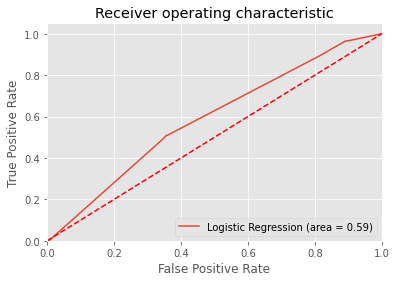


Fold index: 1 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Logistic_Regression
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)


BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

Area under ROC curve: 0.633727778967659


<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

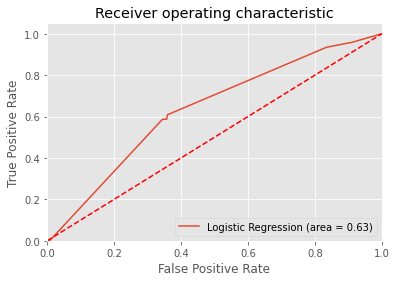


Classifier evaluation for: Naive_Bayes
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Area under ROC curve: 0.633727778967659


<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

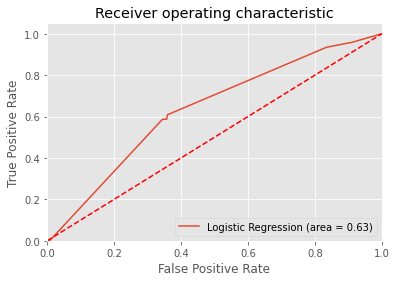


Fold index: 2 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Logistic_Regression
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)


BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

Area under ROC curve: 0.6575354454752319


<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

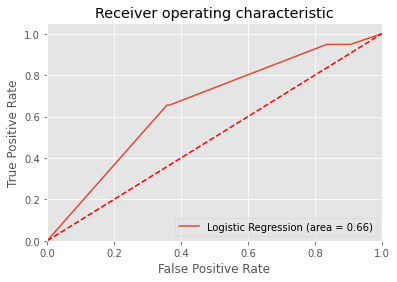


Classifier evaluation for: Naive_Bayes
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Area under ROC curve: 0.6575354454752319


<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

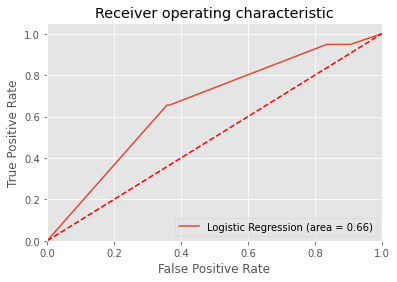


Fold index: 3 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Logistic_Regression
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)


BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

Area under ROC curve: 0.6373879576644552


<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

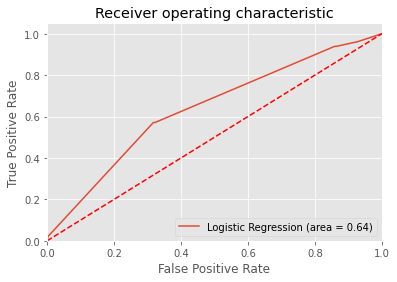


Classifier evaluation for: Naive_Bayes
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Area under ROC curve: 0.6355648959335594


<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

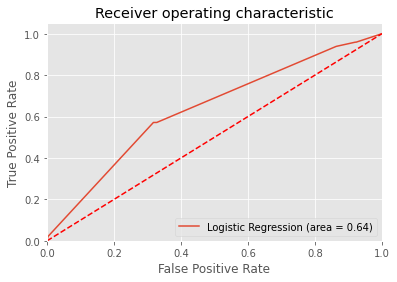


Fold index: 4 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Logistic_Regression
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)


BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

Area under ROC curve: 0.5743993962517295


<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

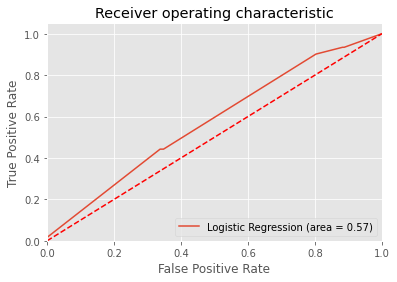


Classifier evaluation for: Naive_Bayes
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Area under ROC curve: 0.5743993962517295


<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

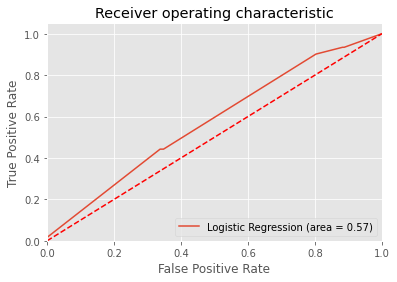


Fold index: 5 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Logistic_Regression
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)


BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

Area under ROC curve: 0.5746839950151327


<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

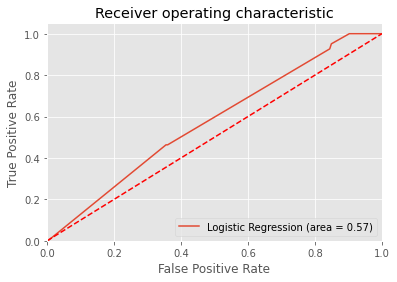


Classifier evaluation for: Naive_Bayes
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Area under ROC curve: 0.5842383241350662


<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

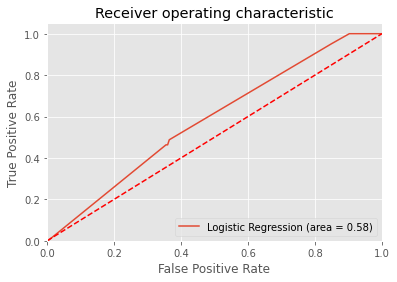


Fold index: 6 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Logistic_Regression
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)


BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

Area under ROC curve: 0.5625116322352502


<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

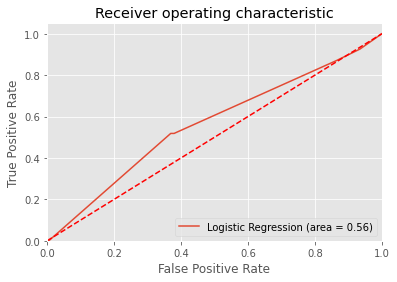


Classifier evaluation for: Naive_Bayes
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Area under ROC curve: 0.5625116322352502


<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

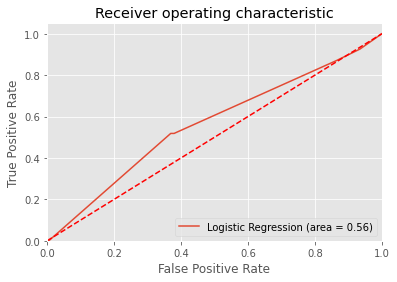


Fold index: 7 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Logistic_Regression
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)


BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

Area under ROC curve: 0.7311441622103387


<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

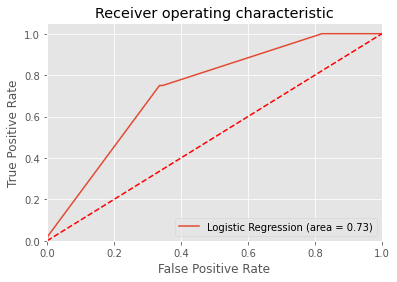


Classifier evaluation for: Naive_Bayes
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Area under ROC curve: 0.7311441622103387


<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

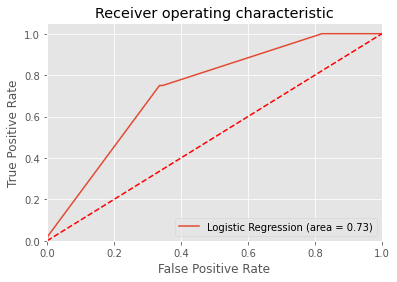


Fold index: 8 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Logistic_Regression
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)


BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

Area under ROC curve: 0.5735328888258382


<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

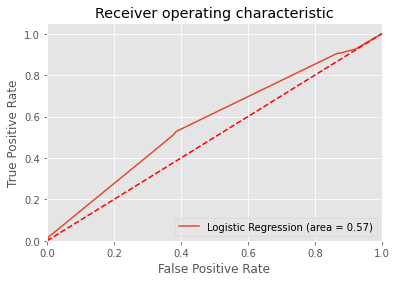


Classifier evaluation for: Naive_Bayes
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Area under ROC curve: 0.5735328888258382


<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

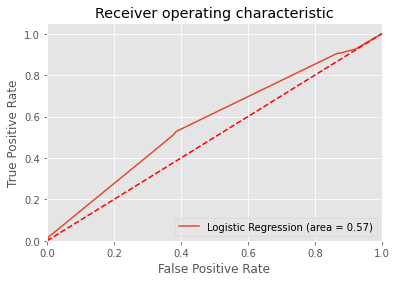


Fold index: 9 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Logistic_Regression
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)


BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

Area under ROC curve: 0.5778268860493612


<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

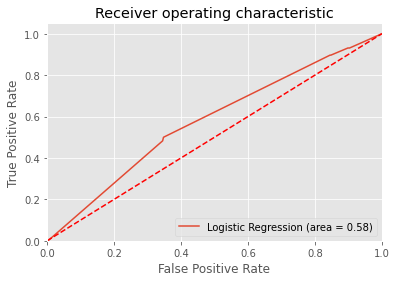


Classifier evaluation for: Naive_Bayes
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Area under ROC curve: 0.5768204095921582


<Figure size 432x288 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

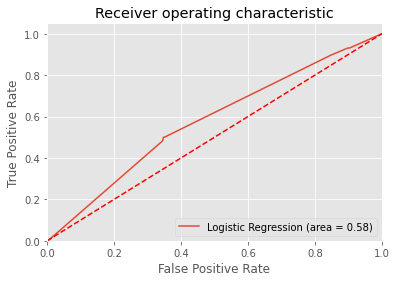


----------------------------------------------
Average results from 10-fold cross-validation

Method                 Area under ROC Curve
Logistic_Regression   0.611060
Naive_Bayes           0.611733
dtype: float64


In [ ]:
kf = KFold(n_splits = N_FOLDS, shuffle=False, random_state = RANDOM_SEED)

# check the splitting process by looking at fold observation counts
index_for_fold = 0  # fold count initialized

for train_index, test_index in kf.split(model_data):
    print('\nFold index:', index_for_fold,
          '------------------------------------------')
#   note that 0:model_data.shape[1]-1 slices for explanatory variables
#   and model_data.shape[1]-1 is the index for the response variable    
    X_train = model_data[train_index, 0:model_data.shape[1]-1]
    X_test = model_data[test_index, 0:model_data.shape[1]-1]
    y_train = model_data[train_index, model_data.shape[1]-1]
    y_test = model_data[test_index, model_data.shape[1]-1]   

    print('\nShape of input data for this fold:',
          '\nData Set: (Observations, Variables)')
    print('X_train:', X_train.shape)
    print('X_test:',X_test.shape)
    print('y_train:', y_train.shape)
    print('y_test:',y_test.shape)

    index_for_method = 0  # initialize
    for name, clf in zip(classifier_names, classifiers):
        print('\nClassifier evaluation for:', name)
        print('  Scikit Learn method:', clf)
        clf.fit(X_train, y_train)  # fit on the train set for this fold
        # evaluate on the test set for this fold
        y_test_predict = clf.predict_proba(X_test)
        fold_method_result = roc_auc_score(y_test, y_test_predict[:,1]) 
        print('Area under ROC curve:', fold_method_result)
        cv_results[index_for_fold, index_for_method] = fold_method_result
  
        logit_roc_auc = roc_auc_score(y_test, y_test_predict[:,1])
        fpr, tpr, thresholds = roc_curve(y_test, y_test_predict[:,1])
        plt.figure()
        plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.savefig('Log_ROC')
        plt.show()
        index_for_method += 1

    index_for_fold += 1

cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = classifier_names

print('\n----------------------------------------------')
print('Average results from ', N_FOLDS, '-fold cross-validation\n',
      '\nMethod                 Area under ROC Curve', sep = '')     
print(cv_results_df.mean())

In [ ]:
# Save the cross-validation results.
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = classifier_names
with open("cv-results.txt", "w") as text_file:
    text_file.write('\nResults from '+ str(N_FOLDS) + '-fold cross-validation\n'+
                     '\nMethod Area under ROC Curve:\n'+ 
                     str(cv_results_df))

464

In [ ]:
pd.options.display.float_format = '{:,.6f}'.format
cv_results_df.mean() # same as the results in the display above

Logistic_Regression   0.611060
Naive_Bayes           0.611733
dtype: float64

## Cross Validation

In [ ]:
# --------------------------------------------------------
# Select method and apply to specific test cases
# --------------------------------------------------------
my_default = np.array([1, 1, 1, 1, 0, 0, 0, 0], np.int32)
my_housing = np.array([1, 1, 0, 0, 1, 1, 0, 0], np.int32)
my_loan = np.array([1, 0, 1, 0, 1, 0, 1, 0], np.int32)

In [ ]:
my_X_test = np.vstack([ my_housing, my_loan, my_default]).T

In [ ]:
# fit logistic regression to full data set
clf = LogisticRegression( solver = 'lbfgs')
X_train = model_data[:, 0:model_data.shape[1]-1]
y_train = model_data[:, model_data.shape[1]-1]
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# predict specific test cases
y_my_test_predict = clf.predict_proba(my_X_test)

In [ ]:
y_scores = clf.decision_function(my_X_test)
y_scores

array([-2.852, -2.207, -3.012, -2.367, -2.113, -1.467, -2.273, -1.627])

In [ ]:
# create DataFrame for displaying test cases and predicted probabilities
my_targeting_df = pd.DataFrame(np.hstack([my_X_test, y_my_test_predict]))
my_targeting_df.columns = ['housing', 'loan', 'default',
                           'predict_NO', 'predict_YES']
print('\n\nLogistic regression model predictions for test cases:')
print(my_targeting_df)



Logistic regression model predictions for test cases:
   housing     loan  default  predict_NO  predict_YES
0 1.000000 1.000000 1.000000    0.945432     0.054568
1 1.000000 0.000000 1.000000    0.900835     0.099165
2 0.000000 1.000000 1.000000    0.953128     0.046872
3 0.000000 0.000000 1.000000    0.914250     0.085750
4 1.000000 1.000000 0.000000    0.892155     0.107845
5 1.000000 0.000000 0.000000    0.812643     0.187357
6 0.000000 1.000000 0.000000    0.906623     0.093377
7 0.000000 0.000000 0.000000    0.835815     0.164185
